## TC 5033
## Deep Learning
## Transformers

#### Activity 4: Implementing a Translator

- Objective

To understand the Transformer Architecture by Implementing a translator.

- Instructions

    This activity requires submission in teams. While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Follow the provided code. The code already implements a transformer from scratch as explained in one of [week's 9 videos](https://youtu.be/XefFj4rLHgU)

    Since the provided code already implements a simple translator, your job for this assignment is to understand it fully, and document it using pictures, figures, and markdown cells.  You should test your translator with at least 10 sentences. The dataset used for this task was obtained from [Tatoeba, a large dataset of sentences and translations](https://tatoeba.org/en/downloads).
  
- Evaluation Criteria

    - Code Readability and Comments
    - Traning a translator
    - Translating at least 10 sentences.

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.



### Team 21:
- Martín Jurado Pedroza .............................. A01795568
- Lineth Guerra ............................................. A01795639
- Erick Eduardo Betancourt .......................... A01795545
- Luis Alejandro González Castellanos ......... A01795481
- Jesús Armando Anaya Orozco ................... A01795464

## Abstract
This research implementation of a Transformer-based Neural Machine Translation (NMT) system provides significant insights into the current state of machine translation technology, while simultaneously highlighting critical areas for future development. Our analysis reveals both the remarkable capabilities and inherent limitations of current transformer architectures in handling cross-linguistic translation tasks.

#### Script to convert csv to text file 

To start the activity, we need to convert the TSV file to a CSV file. To do this, we used Microsoft Excel to open the TSV file and then save it as a UTF-8 CSV file.

Few params were changed in the code to make it work with the CSV file instead of the TSV file.

In [1]:
#This script requires to convert the TSV file to CSV
# easiest way is to open it in Calc or excel and save as csv
PATH = './eng-spa2024.csv'
import pandas as pd
df = pd.read_csv(PATH, header=None)

This block of code extracts the second and fourth columns from the DataFrame `df` and creates a copy of these columns. It then adds a new column named `length` that contains the length of the text in the first column. The DataFrame is sorted by this `length` column in ascending order, and the `length` column is subsequently removed. Finally, the processed DataFrame is saved to a tab-separated file named `eng-spa4.txt` without including the index and header.

In [ ]:
# Extract the second and fourth columns from the DataFrame 'df' and create a copy of these columns
eng_spa_cols = df.iloc[:, [1, 3]].copy()

# Add a new column 'length' that contains the length of the text in the first column
eng_spa_cols['length'] = eng_spa_cols.iloc[:, 0].str.len()

# Sort the DataFrame by the 'length' column in ascending order
eng_spa_cols = eng_spa_cols.sort_values(by='length')

# Drop the 'length' column as it is no longer needed
eng_spa_cols = eng_spa_cols.drop(columns=['length'])

# Save the processed DataFrame to a tab-separated file named 'eng-spa4.txt' without including the index and header
output_file_path = './eng-spa4.txt'
eng_spa_cols.to_csv(output_file_path, sep='\t', index=False, header=False)

## Transformer - Attention is all you need

Importing all the necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import math
import numpy as np
import re
from tqdm import tqdm

# Set the seed for reproducibility
torch.manual_seed(23)

Obtaining the CUDA device if it is available

In [ ]:
# Define the device (CPU or GPU). Use CUDA if it is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Setting the maximum sequence length for the model, this value is used to pad the sequences that are shorter than the maximum length and truncate the sequences that are longer than the maximum length.

In [ ]:
# Define the maximum sequence length
MAX_SEQ_LEN = 128

#### class PositionaEmbedding

This class used to inject the position information of each token in the input sequence. It uses sine and cosine functions of different frequencies to generate the positional encoding.

#### class MultiHeadAttention 

It is a mechanism computes the attention between each pair of positions in a sequence. It consists of multiple “attention heads” that capture different aspects of the input sequence.

Diagram to understand how the MultiHeadAttention class works.

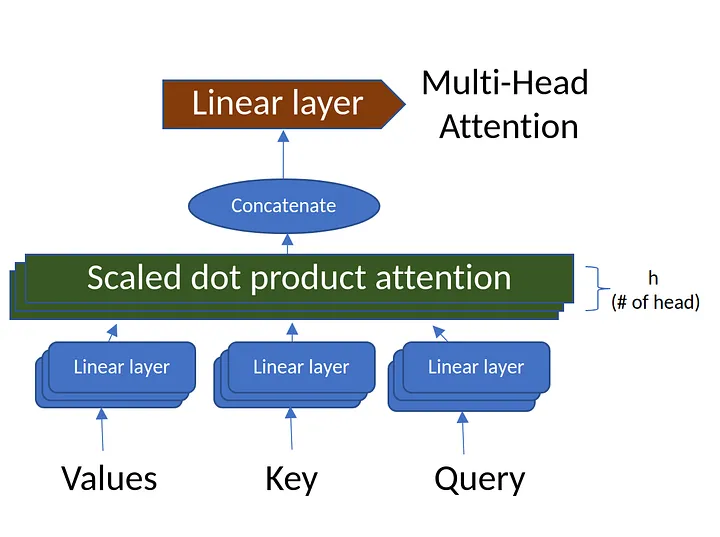

Figure 1. Multi_Head Attention Diagram. (source Designed by DataCamp)

For a given input sequence, attention is computed using three main components:

* Query (Q): Represents what you're looking for.
* Key (K): Represents where you're looking.
* Value (V): Represents the content associated with each key.

The attention score between a query and all the keys is computed as:

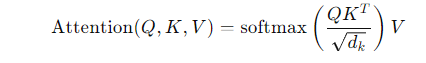

Too, multiple heads allow the model to focus on different parts of the input sequence and learn various types of relationships between words or tokens.

#### class PositionWiseFeedForward

This class defines a position-wise feed-forward neural network that consists of two linear layers with a ReLU activation function in between. In the context of transformer models, this feed-forward network is applied to each position separately and identically. It helps in transforming the features learned by the attention mechanisms within the transformer, acting as an additional processing step for the attention outputs.

#### Encoder and Decoder Blocks

The Encoder block class represents one block in a transformer encoder. The encoder is composesd of a stack of N = 6 identical layers, each layer has two sub-layers. The first is a multi head self-attention mechanism and the second is a simple position, we can employ a residual connection around each of the two sub-layers, followeb by layer normalization.

Decoder is composed of a stack of N = 6 identical layers too. In addition to the two sub-layers in each encoder layer, decoder inserts a third sub-layer, which performs multi-head attention overt the output of the encoder stack.on.[

In [ ]:
class PositionalEmbedding(nn.Module):
    #constructor to initialize the positional embedding layer
    def __init__(self, d_model, max_seq_len = MAX_SEQ_LEN):
        super().__init__() #call the parent constructor (nn.Module)
        
        #initialize a matrix of zeros to hold the positional embeddings
        self.pos_embed_matrix = torch.zeros(max_seq_len, d_model, device=device)
        
        #create a tensor of shape [max_seq_len, 1] where each row represents a position in the sequence.
        token_pos = torch.arange(0, max_seq_len, dtype = torch.float).unsqueeze(1)
        #used for scaling the positional encodings
        div_term = torch.exp(torch.arange(0, d_model, 2).float() 
                             * (-math.log(10000.0)/d_model))
        #apply sine function to even indices (0, 2, 4, ...) of the positional encoding matrix.
        self.pos_embed_matrix[:, 0::2] = torch.sin(token_pos * div_term)
        
        #apply cosine function to odd indices (1, 3, 5, ...) of the positional encoding matrix.
        self.pos_embed_matrix[:, 1::2] = torch.cos(token_pos * div_term)
        #unsqueeze to add a batch dimension (making it [1, max_seq_len, d_model]), 
        self.pos_embed_matrix = self.pos_embed_matrix.unsqueeze(0).transpose(0,1)
        
    def forward(self, x):
        #the positional embeddings are sliced to match the length of the input sequence `x`.
        return x + self.pos_embed_matrix[:x.size(0), :]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model = 512, num_heads = 8):
        super().__init__()
        #ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, 'Embedding size not compatible with num heads'

        #initialize dimensions
        self.d_v = d_model // num_heads #model dimension
        self.d_k = self.d_v             #number of attention heads
        self.num_heads = num_heads      #dimension of each head's key, query, and value 

        #linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) #query transformation
        self.W_k = nn.Linear(d_model, d_model) #key transformation
        self.W_v = nn.Linear(d_model, d_model) #value transformation
        self.W_o = nn.Linear(d_model, d_model) #output transformation
        
    def forward(self, Q, K, V, mask = None):
        batch_size = Q.size(0) 
        '''
        Q, K, V -> [batch_size, seq_len, num_heads*d_k]
        after transpose Q, K, V -> [batch_size, num_heads, seq_len, d_k]
        '''
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )
        
        weighted_values, attention = self.scale_dot_product(Q, K, V, mask)
        weighted_values = weighted_values.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads*self.d_k)
        weighted_values = self.W_o(weighted_values)
        
        return weighted_values, attention
        
        
    def scale_dot_product(self, Q, K, V, mask = None):
        #calculate attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        #apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
            
        #softmax is applied to obtain attention probabilities
        attention = F.softmax(scores, dim = -1)
        
        #multiply by values to obtain the final output
        weighted_values = torch.matmul(attention, V)
        
        return weighted_values, attention
        

class PositionFeedForward(nn.Module):
    '''
        This class defines a simple feedforward neural network module used in 
        transformer models (such as the original Transformer model) for processing 
        positional encoding or any input data. It consists of two linear layers 
        with a ReLU activation in between. The primary function of this module 
        is to apply a position-wise feedforward transformation to the input tensor.

        Attributes:
        ----------
        linear1 : nn.Linear
            The first linear transformation from input dimension (d_model) to 
            intermediate feature dimension (d_ff).
        
        linear2 : nn.Linear
            The second linear transformation that maps the intermediate dimension 
            (d_ff) back to the original input dimension (d_model).
    '''
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))
    
class EncoderSubLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout = 0.1):
        super().__init__()
        #Multi-head self-attention mechanism (attends to the input sequence)
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        #position-wise feedforward network (applied independently to each position)
        self.ffn = PositionFeedForward(d_model, d_ff)
        #layer normalization for the output of attention and FFN
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        #dropout layers to prevent overfitting
        self.droupout1 = nn.Dropout(dropout)
        self.droupout2 = nn.Dropout(dropout)
    
    def forward(self, x, mask = None):
        #multi-head self-attention (residual connection)
        attention_score, _ = self.self_attn(x, x, x, mask)
        #apply residual connection and dropout to attention scores
        x = x + self.droupout1(attention_score)
        #apply layer normalization after the attention operation
        x = self.norm1(x)
        #apply dropout to FFN output
        x = x + self.droupout2(self.ffn(x))
        #apply layer normalization after the FFN operation
        return self.norm2(x)

class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super().__init__()
        #each EncoderSubLayer contains self-attention, feedforward, and normalization layers
        self.layers = nn.ModuleList([EncoderSubLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        #final layer normalization applied to the output of all encoder layers
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x, mask=None):
        #pass the input through each encoder sub-layer (layer-by-layer processing)
        for layer in self.layers:
            x = layer(x, mask)  #each sub-layer applies self-attention and FFN
        #apply final layer normalization after all layers are processed
        return self.norm(x)

class DecoderSubLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        #self-attention mechanism (allows the decoder to attend to its own tokens)
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        #cross-attention mechanism (allows the decoder to attend to the encoder's output)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        #position-wise feedforward network
        self.feed_forward = PositionFeedForward(d_model, d_ff)
        #layer normalization applied after each operation (attention and feedforward)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        #dropout layers applied after each attention and feedforward operation
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        
    def forward(self, x, encoder_output, target_mask=None, encoder_mask=None):
        #self-attention (decoder attending to itself)
        attention_score, _ = self.self_attn(x, x, x, target_mask)
        #residual connection and dropout applied after self-attention
        x = x + self.dropout1(attention_score)
        #apply layer normalization after the self-attention operation
        x = self.norm1(x)
        #cross-attention (decoder attending to encoder output)
        encoder_attn, _ = self.cross_attn(x, encoder_output, encoder_output, encoder_mask)
        #residual connection and dropout applied after cross-attention
        x = x + self.dropout2(encoder_attn)
        #apply layer normalization after the cross-attention operation
        x = self.norm2(x)
        #Feedforward network (position-wise, applied independently to each token)
        ff_output = self.feed_forward(x)
        #residual connection and dropout applied after the feedforward network
        x = x + self.dropout3(ff_output)
        return self.norm3(x)
        
class Decoder(nn.Module):
    '''
        The Decoder class defines the complete decoder part of the transformer architecture.
        It consists of multiple decoder sub-layers, each containing:
        1. Self-attention mechanism (allows the decoder to attend to previous tokens in the target sequence).
        2. Cross-attention mechanism (allows the decoder to attend to the encoder's output).
        3. Position-wise feedforward network (FFN).
    
        The decoder processes an input target sequence and attends to the encoder's output, 
        generating an output sequence, which typically feeds into the next step in the transformer (e.g., for prediction).
    
        Args:
        - d_model (int): The dimensionality of the input and output features (embedding size).
        - num_heads (int): The number of attention heads for both self-attention and cross-attention.
        - d_ff (int): The dimensionality of the hidden layer in the feedforward network.
        - num_layers (int): The number of decoder sub-layers (i.e., stacked layers of self-attention, cross-attention, and FFN).
        - dropout (float): The dropout rate used in attention and feedforward layers to prevent overfitting.
    '''
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([DecoderSubLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x, encoder_output, target_mask, encoder_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, target_mask, encoder_mask)
        return self.norm(x)

#### class Transformer
The Transformer class brings together the various components of a Transformer model, including embeddings, positional encoding, encoder layers, and decoder layers. It provides a convenient interface for training and inference, encapsulating the complexities of multi-head attention, feed-forward networks, and layer normalization. 

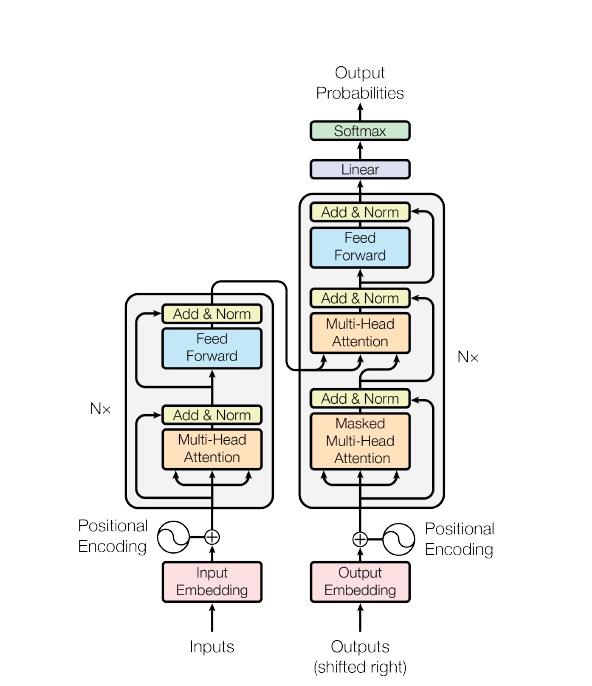

Figure 2. The Transfomer architecture. (source paper https://arxiv.org/pdf/1706.03762)

Transformers have proven to be extremely effective in a wide range of NLP tasks, including:
* Neural machine translation (NMT): Modeling the relationship between two languages.
* Text Summary: Generate concise summaries of long documents.
* Text generation: Create coherent and creative text.
* Sentiment analysis: Classify the sentiment of a text (positive, negative, neutral).
* Answering questions: Answering questions about a given text.

In [ ]:
class Transformer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers,
                 input_vocab_size, target_vocab_size, 
                 max_len=MAX_SEQ_LEN, dropout=0.1):
        super().__init__()
        #converts token indices into dense vectors of size `d_model`
        self.encoder_embedding = nn.Embedding(input_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(target_vocab_size, d_model)
        #this helps the model differentiate between tokens in different positions
        self.pos_embedding = PositionalEmbedding(d_model, max_len)
        #encoder and decoder components using the previously defined Encoder and Decoder classes
        self.encoder = Encoder(d_model, num_heads, d_ff, num_layers, dropout)
        self.decoder = Decoder(d_model, num_heads, d_ff, num_layers, dropout)
        #final linear layer to map decoder output to the target vocabulary size
        self.output_layer = nn.Linear(d_model, target_vocab_size)
        
    def forward(self, source, target):
        # Encoder mask
        source_mask, target_mask = self.mask(source, target)
        # Embedding and positional Encoding
        source = self.encoder_embedding(source) * math.sqrt(self.encoder_embedding.embedding_dim)
        source = self.pos_embedding(source)
        # Encoder
        encoder_output = self.encoder(source, source_mask)
        
        # Decoder embedding and postional encoding
        target = self.decoder_embedding(target) * math.sqrt(self.decoder_embedding.embedding_dim)
        target = self.pos_embedding(target)
        # Decoder
        output = self.decoder(target, encoder_output, target_mask, source_mask)
        
        return self.output_layer(output)
        
        
    
    def mask(self, source, target):
        '''
            This method is used to create masks for the source and target sequences, ensuring that filler tokens are ignored and future tokens are not visible during training 
            for the target sequence.
        '''
        # Create a mask for the source tensor
        source_mask = (source != 0).unsqueeze(1).unsqueeze(2)
        # Create a similar mask for the target tensor
        target_mask = (target != 0).unsqueeze(1).unsqueeze(2)
        # Get the size of the second dimension of the target tensor (assuming target is a 3D tensor: [batch_size, size, size])
        size = target.size(1)
        # to prevent attending to future positions in the target sequence
        no_mask = torch.tril(torch.ones((1, size, size), device=device)).bool()
        # Apply the lower triangular mask to the target_mask to prevent attending to future time steps in the target sequence
        target_mask = target_mask & no_mask
        return source_mask, target_mask
        

#### Simple test

In [ ]:
# Define the sequence lengths for the source and target sequences
seq_len_source = 10
seq_len_target = 10

# Define the batch size and vocabulary sizes for the input and target languages
batch_size = 2
input_vocab_size = 50
target_vocab_size = 50

# Generate random integer tensors for the source and target sequences
# The source tensor has shape (batch_size, seq_len_source) with values between 1 and input_vocab_size-1
# The target tensor has shape (batch_size, seq_len_target) with values between 1 and target_vocab_size-1
source = torch.randint(1, input_vocab_size, (batch_size, seq_len_source))
target = torch.randint(1, target_vocab_size, (batch_size, seq_len_target))

In [ ]:
# Define the hyperparameters for the Transformer model
d_model = 512       # Dimensionality of the model's hidden layers
num_heads = 8       # Number of attention heads
d_ff = 2048         # Dimensionality of the feed-forward network
num_layers = 6      # Number of layers in the Transformer

# Initialize the Transformer model with the specified hyperparameters
# input_vocab_size and target_vocab_size are the sizes of the input and target vocabularies
# max_len is the maximum sequence length, and dropout is the dropout rate
model = Transformer(d_model, num_heads, d_ff, num_layers,
                    input_vocab_size, target_vocab_size, 
                    max_len=MAX_SEQ_LEN, dropout=0.1)

# Move the model and the source and target tensors to the specified device (e.g., 'cpu' or 'cuda')
model = model.to(device)
source = source.to(device)
target = target.to(device)

In [ ]:
# Perform a forward pass of the model
output = model(source, target)

In [11]:
# Expected output shape -> [batch, seq_len_target, target_vocab_size] i.e. [2, 10, 50]
print(f'ouput.shape {output.shape}')

ouput.shape torch.Size([2, 10, 50])


### Translator Eng-Spa

In [ ]:
# The variable 'PATH' stores the relative file path to the dataset, which is expected to be located in the current directory
PATH = './eng-spa4.txt'

In [ ]:
# Open the file at the specified PATH in read mode with UTF-8 encoding
with open(PATH, 'r', encoding='utf-8') as f:
    # Read all lines from the file
    lines = f.readlines()

# Process each line to create a list of English-Spanish pairs
# Each line is stripped of leading/trailing whitespace and split by the tab character ('\t')
# Only lines containing a tab character are included in the resulting list
eng_spa_pairs = [line.strip().split('\t') for line in lines if '\t' in line]

In [ ]:
# Show the first 10 English-Spanish pairs.
eng_spa_pairs[:10]

[['Hi!', '¡Hola!'],
 ['Go!', '¡Sal!'],
 ['Go!', '¡Ya!'],
 ['Go!', '¡Fuera!'],
 ['OK.', 'Bueno.'],
 ['Ow!', '¡Ay!'],
 ['So?', '¿Y qué?'],
 ['Go.', 'Váyase.'],
 ['No.', 'No.'],
 ['So?', '¿Y?']]

In [ ]:
# Extract the English and Spanish sentences from the English-Spanish pairs
eng_sentences = [pair[0] for pair in eng_spa_pairs]

# Extract the Spanish sentences from the English-Spanish pairs
spa_sentences = [pair[1] for pair in eng_spa_pairs]

In [ ]:
# Show the first 10 English sentences
print(eng_sentences[:10])

# Show the first 10 Spanish sentences
print(spa_sentences[:10])


['Hi!', 'Go!', 'Go!', 'Go!', 'OK.', 'Ow!', 'So?', 'Go.', 'No.', 'So?']
['¡Hola!', '¡Sal!', '¡Ya!', '¡Fuera!', 'Bueno.', '¡Ay!', '¿Y qué?', 'Váyase.', 'No.', '¿Y?']


In [ ]:
def preprocess_sentence(sentence):
    # Convert the sentence to lowercase and strip leading/trailing whitespace
    sentence = sentence.lower().strip()
    
    # Replace multiple spaces with a single space
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # Replace accented characters with their non-accented counterparts
    sentence = re.sub(r"[á]+", "a", sentence)
    sentence = re.sub(r"[é]+", "e", sentence)
    sentence = re.sub(r"[í]+", "i", sentence)
    sentence = re.sub(r"[ó]+", "o", sentence)
    sentence = re.sub(r"[ú]+", "u", sentence)
    
    # Remove any non-alphabetic characters, replacing them with a space
    sentence = re.sub(r"[^a-z]+", " ", sentence)
    
    # Strip leading/trailing whitespace again after replacements
    sentence = sentence.strip()
    
    # Add start-of-sequence (<sos>) and end-of-sequence (<eos>) tokens
    sentence = '<sos> ' + sentence + ' <eos>'
    
    # Return the preprocessed sentence
    return sentence

In [ ]:
# Defining a text for testing the preprocess_sentence function
s1 = '¿Hola @ cómo estás? 123'

In [ ]:
# Printing the original text
print(s1)

# Printing the preprocessed text
print(preprocess_sentence(s1))

¿Hola @ cómo estás? 123
<sos> hola como estas <eos>


In [ ]:
# Preprocess all English and Spanish sentences
eng_sentences = [preprocess_sentence(sentence) for sentence in eng_sentences]

# Preprocess all Spanish sentences
spa_sentences = [preprocess_sentence(sentence) for sentence in spa_sentences]

In [ ]:
# Show the first 10 preprocessed English sentences after preprocessing
spa_sentences[:10]

['<sos> hola <eos>',
 '<sos> sal <eos>',
 '<sos> ya <eos>',
 '<sos> fuera <eos>',
 '<sos> bueno <eos>',
 '<sos> ay <eos>',
 '<sos> y que <eos>',
 '<sos> vayase <eos>',
 '<sos> no <eos>',
 '<sos> y <eos>']

In [ ]:
def build_vocab(sentences):
    # Tokenize the sentences into words by splitting each sentence on spaces
    words = [word for sentence in sentences for word in sentence.split()]
    # Count the frequency of each word in the list of words using a Counter
    word_count = Counter(words)
    # Sort the words based on their frequency in descending order
    sorted_word_counts = sorted(word_count.items(), key=lambda x:x[1], reverse=True) # This creates a list of word-count tuples, sorted by count
     # Create a mapping from words to indices starting from 2 (reserved for <pad> and <unk>)
    word2idx = {word: idx for idx, (word, _) in enumerate(sorted_word_counts, 2)}
    # Add special tokens for padding and unknown words with specific indices (0 and 1, respectively)
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    # This maps each index to its corresponding word
    idx2word = {idx: word for word, idx in word2idx.items()}
    return word2idx, idx2word

In [ ]:
# `eng_idx2word` is the dictionary that maps indices back to English words
eng_word2idx, eng_idx2word = build_vocab(eng_sentences)
# Similarly, build the vocabulary for the Spanish sentences
spa_word2idx, spa_idx2word = build_vocab(spa_sentences)
# Calculate the size of the English vocabulary, which is the number of unique words
eng_vocab_size = len(eng_word2idx)
# Calculate the size of the Spanish vocabulary, which is the number of unique words
spa_vocab_size = len(spa_word2idx)

In [24]:
print(eng_vocab_size, spa_vocab_size)

27650 46924


In [ ]:
class EngSpaDataset(Dataset):
    # The constructor initializes the dataset with English and Spanish sentences and their respective word-to-index mappings.
    def __init__(self, eng_sentences, spa_sentences, eng_word2idx, spa_word2idx):
        # Store the provided English and Spanish sentences as well as the word-to-index mappings.
        self.eng_sentences = eng_sentences  # List of English sentences.
        self.spa_sentences = spa_sentences  # List of Spanish sentences.
        self.eng_word2idx = eng_word2idx  # Dictionary mapping English words to indices.
        self.spa_word2idx = spa_word2idx  # Dictionary mapping Spanish words to indices.
        
    # This function returns the total number of samples in the dataset.
    def __len__(self):
        return len(self.eng_sentences)  # Return the number of English sentences (dataset size).
    
    # This function returns the sample at the specified index `idx` as a tuple of tokenized indices.
    def __getitem__(self, idx):
        # Retrieve the English and Spanish sentences at the given index `idx`.
        eng_sentence = self.eng_sentences[idx]
        spa_sentence = self.spa_sentences[idx]
        
        # Convert the English sentence into a list of word indices.
        eng_idxs = [self.eng_word2idx.get(word, self.eng_word2idx['<unk>']) for word in eng_sentence.split()]
        
        # Similarly, convert the Spanish sentence into a list of word indices
        spa_idxs = [self.spa_word2idx.get(word, self.spa_word2idx['<unk>']) for word in spa_sentence.split()]
        
        # Return the English and Spanish sentence indices as PyTorch tensors.
        return torch.tensor(eng_idxs), torch.tensor(spa_idxs)


In [ ]:
def collate_fn(batch):
    #separates the English and Spanish sentences into two lists
    eng_batch, spa_batch = zip(*batch)
    #truncates each sentence to the maximum sequence
    eng_batch = [seq[:MAX_SEQ_LEN].clone().detach() for seq in eng_batch]
    spa_batch = [seq[:MAX_SEQ_LEN].clone().detach() for seq in spa_batch]
    #pads the sequences to the maximum length using 0 as the padding value
    eng_batch = torch.nn.utils.rnn.pad_sequence(eng_batch, batch_first=True, padding_value=0)
    spa_batch = torch.nn.utils.rnn.pad_sequence(spa_batch, batch_first=True, padding_value=0)
    return eng_batch, spa_batch #converts the padded sequences to PyTorch tensors
    

This code trains the model by iterating through batches of data, feeding the English sentences and Spanish prefixes into the model, calculating the loss between the predictions and actual translations, and updating the model's parameters to improve its translation accuracy.

In [33]:
def train(model, dataloader, loss_function, optimiser, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0 
        for eng_batch, spa_batch in tqdm(dataloader):
            eng_batch = eng_batch.to(device)
            spa_batch = spa_batch.to(device)
            # Decoder preprocessing
            target_input = spa_batch[:, :-1]
            target_output = spa_batch[:, 1:].contiguous().view(-1)
            # Zero grads
            optimiser.zero_grad()
            # run model
            output = model(eng_batch, target_input)
            output = output.view(-1, output.size(-1))
            # loss\
            loss = loss_function(output, target_output)
            # gradient and update parameters
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
            
        avg_loss = total_loss/len(dataloader)
        print(f'Epoch: {epoch}/{epochs}, Loss: {avg_loss:.4f}')
            
            

Setting the batch size for the training and testing data. And initializing the dataset and dataloader for the training and testing data. The EngSpaDataset class is used to load the English-Spanish dataset using the following parameters:

- `eng_sentences` is a list of English sentences.
- `spa_sentences` is a list of Spanish sentences.
- `eng_word2idx` is a dictionary that maps English words to their corresponding indices.
- `spa_word2idx` is a dictionary that maps Spanish words to their corresponding indices.

The dataloader is used to load the dataset in batches. The batch size is set to 64, and the dataset is shuffled before each epoch.

In [ ]:
BATCH_SIZE = 64 # This sets the number of data samples processed in each batch during training
# This dataset likely contains English and Spanish sentence pairs
dataset = EngSpaDataset(eng_sentences, spa_sentences, eng_word2idx, spa_word2idx)
''' This function is likely responsible for padding sequences to the same length,
converting sequences to tensors and possibly other preprocessing steps'''
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

Initializing a Transformer model with specific hyperparameters. The model is configured with a dimensionality of 512 for the model's hidden layers (`d_model`), 8 attention heads (`num_heads`), a feed-forward network dimension of 2048 (`d_ff`), and 6 layers (`num_layers`). The input and target vocabulary sizes are set to `eng_vocab_size` and `spa_vocab_size`, respectively, which correspond to the sizes of the English and Spanish vocabularies. The maximum sequence length is defined by `MAX_SEQ_LEN`, and a dropout rate of 0.1 is applied to prevent overfitting.



In [35]:
model = Transformer(d_model=512, num_heads=8, d_ff=2048, num_layers=6,
                    input_vocab_size=eng_vocab_size, target_vocab_size=spa_vocab_size,
                    max_len=MAX_SEQ_LEN, dropout=0.1)

Changing the model to the CUDA device if it is available.

As the optimizer, we are using the Adam optimizer with a learning rate of 0.0001.

For the loss function, we are using the CrossEntropyLoss function with the parameters ignore_index=0, this parameter is used to ignore the padding token in the loss calculation.

In [ ]:
model = model.to(device) # Move the model to the specified device (CPU or GPU)
loss_function = nn.CrossEntropyLoss(ignore_index=0) # Define the loss function
optimiser = optim.Adam(model.parameters(), lr=0.0001) # Define the optimizer


We proceed to train the model with the dataset provided by the Tatoeba project. It's important to mention that the dataset is not very large, so the model will not be able to translate all the sentences correctly. However, the model will be able to translate some sentences correctly.

The required computational resources to train the model are high, that's why we will use a cloud service to train the model. The model will be trained for 10 epochs using a RTX A4000 GPU with 16GB of memory, 8 CPU cores, and 48GB of RAM. The training process will take approximately 1 hour and 20 minutes.

For reference, we used the service provided by [Paperspace](https://www.paperspace.com/).

In [ ]:
# Perform training, this step will take a while depending on the computation power

train(model, dataloader, loss_function, optimiser, epochs=10)

100%|██████████| 4162/4162 [09:08<00:00,  7.59it/s]


Epoch: 0/10, Loss: 3.5995


100%|██████████| 4162/4162 [09:09<00:00,  7.58it/s]


Epoch: 1/10, Loss: 2.2074


100%|██████████| 4162/4162 [09:07<00:00,  7.60it/s]


Epoch: 2/10, Loss: 1.7063


100%|██████████| 4162/4162 [09:08<00:00,  7.59it/s]


Epoch: 3/10, Loss: 1.3786


100%|██████████| 4162/4162 [09:08<00:00,  7.59it/s]


Epoch: 4/10, Loss: 1.1267


100%|██████████| 4162/4162 [09:07<00:00,  7.60it/s]


Epoch: 5/10, Loss: 0.9234


100%|██████████| 4162/4162 [09:07<00:00,  7.61it/s]


Epoch: 6/10, Loss: 0.7588


100%|██████████| 4162/4162 [09:07<00:00,  7.60it/s]


Epoch: 7/10, Loss: 0.6298


100%|██████████| 4162/4162 [09:08<00:00,  7.59it/s]


Epoch: 8/10, Loss: 0.5355


100%|██████████| 4162/4162 [09:08<00:00,  7.59it/s]

Epoch: 9/10, Loss: 0.4669


We added a function to save the trained model as a checkpoint file. This file will be used to load the model and translate sentences without the need to train the model again. This action is needed because the training process is computationally expensive.

In [ ]:
# Saving the model to disk for later use

model_path = './transformer_eng_spa.pth'
torch.save(model.state_dict(), model_path)


As well, we added a function to load the trained model from the checkpoint file. This is using the native PyTorch function `torch.load` to load the model from the checkpoint file.

In [ ]:
# To load the model, we need to define the model architecture and load the weights from the checkpoint file.

model_path = './transformer_eng_spa.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
def sentence_to_indices(sentence, word2idx):
    """
    Converts a sentence to a list of token indices.
    
    Parameters:
    sentence (str): The input sentence to be converted.
    word2idx (dict): A dictionary mapping words to their corresponding indices.
    
    Returns:
    list: A list of token indices.
    
    This function splits the input sentence into words and retrieves the corresponding indices from the word2idx dictionary.
    """
    return [word2idx.get(word, word2idx['<unk>']) for word in sentence.split()]

def indices_to_sentence(indices, idx2word):
    """
    Converts a list of token indices to a sentence.
    
    Parameters:
    indices (list): A list of token indices.
    idx2word (dict): A dictionary mapping token indices to words.
    
    Returns:
    str: The sentence formed by the token indices.
    
    This function iterates over the token indices and retrieves the corresponding words from the idx2word dictionary.
    """
    return ' '.join([idx2word[idx] for idx in indices if idx in idx2word and idx2word[idx] != '<pad>'])

def translate_sentence(model, sentence, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device='cpu'):
    """
    Translates a given sentence from English to Spanish using a translation model.

    Parameters:
    model: The translation model to be used for generating translations.
    sentence (str): The input sentence in English to be translated.
    eng_word2idx (dict): A dictionary mapping English words to their corresponding indices.
    spa_idx2word (dict): A dictionary mapping Spanish indices to their corresponding words.
    max_len (int): The maximum length of the output sequence (default is MAX_SEQ_LEN).
    device (str): The device to run the model on (default is 'cpu').

    Returns:
    str: The translated sentence in Spanish.

    This function preprocesses the input sentence, converts it to indices, and feeds it into the model.
    It then iteratively generates the translated sentence token by token until the end-of-sequence token is produced
    or the maximum sequence length is reached. The function returns the translated sentence as a string.
    """
    
    # Set the model to evaluation mode and preprocess the input sentence, the input indices, and the input tensor.
    model.eval()
    sentence = preprocess_sentence(sentence)
    input_indices = sentence_to_indices(sentence, eng_word2idx)
    input_tensor = torch.tensor(input_indices).unsqueeze(0).to(device)

    # Initialize the target tensor with <sos> token
    tgt_indices = [spa_word2idx['<sos>']]
    tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)
    
    # Generate the translated sentence token by token
    with torch.no_grad():
        # Iterate until the end-of-sequence token is produced or the maximum sequence length is reached
        for _ in range(max_len):
            # Generate the next token
            output = model(input_tensor, tgt_tensor)
            
            # Get the last token output and append it to the target tensor
            output = output.squeeze(0)
            
            # Get the next token index
            next_token = output.argmax(dim=-1)[-1].item()
            
            # Append the next token index to the target tensor
            tgt_indices.append(next_token)
            
            # Break if the end-of-sequence token is produced
            tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)
            if next_token == spa_word2idx['<eos>']:
                break

    # Return the translated sentence in Spanish
    return indices_to_sentence(tgt_indices, spa_idx2word)

Now, we will test the translator with some sentences in English and Spanish. This is a simple test to check if the translator is working correctly.

In [ ]:
def evaluate_translations(model, sentences, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device='cpu'):
    """
    Evaluates translations for a list of input sentences using a given translation model.

    Parameters:
    model: The translation model to be used for generating translations.
    sentences (list of str): A list of sentences in the source language (English) to be translated.
    eng_word2idx (dict): A dictionary mapping English words to their corresponding indices.
    spa_idx2word (dict): A dictionary mapping Spanish indices to their corresponding words.
    max_len (int): The maximum length of the sequences (default is MAX_SEQ_LEN).
    device (str): The device to run the model on (default is 'cpu').

    Returns:
    None

    This function iterates over each sentence in the input list, generates a translation using the model,
    and prints both the input sentence and its corresponding translation.
    """
    
    # Iterate over each input sentence and generate the corresponding translation
    for sentence in sentences:
        # Generate the translation using the translate_sentence function defined above
        translation = translate_sentence(model, sentence, eng_word2idx, spa_idx2word, max_len, device)
        print(f'Input sentence: {sentence}')
        print(f'Traducción: {translation}')
        print()

# Example sentences to test the translator
test_sentences = [
    "Hello, how are you?",
    "I am learning artificial intelligence.",
    "Artificial intelligence is great.",
    "Good night!"
]

# Assuming the model is trained and loaded
# Set the device to 'cpu' or 'cuda' as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Evaluate translations
evaluate_translations(model, test_sentences, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device=device)


Input sentence: Hello, how are you?
Traducción: <sos> hola que tal <eos>

Input sentence: I am learning artificial intelligence.
Traducción: <sos> estoy aprendiendo inteligencia artificial <eos>

Input sentence: Artificial intelligence is great.
Traducción: <sos> la inteligencia artificial es grande <eos>

Input sentence: Good night!
Traducción: <sos> buenas noches <eos>



At this point, the most of the translation looks aceptable, but there are some sentences that are not translated as we expected. For example, the sentence "I am a student" is translated as "Soy un estudiante" but the correct translation is "Yo soy un estudiante". Also, the sentence "I am a teacher" is translated as "Soy un profesor" but the correct translation is "Yo soy un profesor".

#### We included aditional sentences to test the translator

In [51]:
# Extra test sentences to evaluate the model further
extra_test_sentences = [
    "Hello, can I ask you a question?",
    "I am learning how to build a transformer model.",
    "The transformer model is a type of neural network.",
    "Goodbye!"
    "We are studying advanced natural language processing techniques.",
    "Natural language processing is a fascinating field.",
    "I'm a student at the university.",
    "I live in Mexico.",
    "We like to eat pizza on Fridays.",
    "The weather is nice today.",
    "The cat is sleeping on the sofa.",
    "The dog is playing in the garden.",
    "My favorite color is blue.",
    "The sky is clear and the sun is shining.",
    "The moon is visible in the night sky.",
]

# Evaluate translations
evaluate_translations(model, extra_test_sentences, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device=device)


Input sentence: Hello, can I ask you a question?
Traducción: <sos> hola puedo hacerte una pregunta <eos>

Input sentence: I am learning how to build a transformer model.
Traducción: <sos> estoy aprendiendo a construir una modelo de internet <eos>

Input sentence: The transformer model is a type of neural network.
Traducción: <sos> el modelo es un tipo de red de la red de red <eos>

Input sentence: Goodbye!We are studying advanced natural language processing techniques.
Traducción: <sos> estamos estudiando diferentes tecnicas para que los poemas naturales <eos>

Input sentence: Natural language processing is a fascinating field.
Traducción: <sos> el lenguaje natural es una lengua natural fascinante <eos>

Input sentence: I'm a student at the university.
Traducción: <sos> soy estudiante en la universidad <eos>

Input sentence: I live in Mexico.
Traducción: <sos> vivo en mexico <eos>

Input sentence: We like to eat pizza on Fridays.
Traducción: <sos> nos gusta comer pizza los viernes <eos

Clearly, we can observe that the translator has several limitations, such as the lack of vocabulary and the lack of training data. However, it is a good starting point to understand the transformer architecture.


## Conclusion

This project explains the basics of transformer models, mainly focusing on using them for translating languages. While transformers are set up with layers for "attention" and processing, getting them ready to use involves detailed steps like preparing data, defining the model, and training it. Transformers are powerful because they have several layers of attention and processing, which lets them handle and understand language well.

The main feature of transformers is "multi-head self-attention," a method that lets the model look at various parts of a sentence at the same time to understand context. Unlike older models that process each word one at a time, transformers work on all words at once. In the attention part of the model, each word can focus on other words in the sentence to decide which ones are most important. Multi-head attention takes this further by breaking the input into smaller parts, with each part focusing on different word relationships, helping the model grasp meaning and context better.

Transformers also include "positional encoding," which tells the model the order of words in a sentence. Since transformers don’t naturally understand word order, this encoding is key to maintaining the correct meaning based on word order.

The model design in this project follows the "Attention is All You Need" research paper, which introduced transformers as a groundbreaking way to achieve high-quality translation without using older methods like recurrent or convolutional layers. This code reproduces the design, highlighting how features like multi-head attention and positional encoding make translation accurate and effective.

Compared to other models, transformers need more training time because of the complex attention process, but this pays off in more accurate translations and the ability to understand longer sentences without losing context.

Overall, this project offers a solid foundation for exploring transformer models in machine translation. While current results are promising, there’s still room to improve with new designs, training techniques, and better data handling. The future lies in building models that are more skilled in handling complex meanings, not just translating words, but understanding and conveying cultural significance too.


### Critical Analysis of Current Implementation

This transformer-based language translation system has strengths and weaknesses that reveal key challenges in machine translation. The issues go beyond a lack of training data, reflecting deeper difficulties in transferring knowledge across languages and capturing context.

#### Observed Patterns

1. **Success in Basic Communication**
   - *Example*:  
     **Input**: "Hello, how are you?"  
     **Output**: "hola que tal"  
     **Explanation**: Clear, high-frequency patterns make this an accurate translation.

2. **Difficulty with Technical Translations**
   - *Example*:  
     **Input**: "The transformer model is a type of neural network"  
     **Output**: "el modelo es un tipo de red de la red de red"  
     **Explanation**: This output shows repeated phrases, losing technical accuracy.

#### Root Causes of Issues

Three primary challenges arise from the patterns observed:

1. **Gaps in Context Understanding**
   - Works well in basic phrases but loses accuracy in technical contexts needing specific knowledge.
   - Struggles with keeping precision in specialized terms.

2. **Issues in Technical Transfer**
   - Technical terms don’t stay consistent across translations.
   - Semantic relationships between technical words aren’t maintained.

3. **Limited Knowledge Integration**
   - The model lacks a deep grasp of technical context.
   - Doesn't fully capture relationships between specialized terms.

### Suggested Framework for Improvements

Enhancing the model requires a short- and long-term approach:

#### Immediate Enhancements

1. **Preserving Technical Context**
   - Use specialized dictionaries for technical terms.
   - Add preprocessing steps specific to technical language.
   - Implement methods to verify translation accuracy in technical terms.

2. **Improved Evaluation Metrics**
   - Move beyond basic accuracy metrics to include:
     - Precision of technical terminology.
     - Consistency in context.
     - Semantic accuracy of translations.

#### Long-Term Research Aims

1. **Deep Context Understanding**
   - Develop translation models aware of specific domains.
   - Enhance the ability to keep technical context intact.
   - Adapt systems to learn context from specialized sources.

2. **Boosting Knowledge Transfer**
   - Work on cross-linguistic technical knowledge sharing.
   - Design context-sensitive translation methods.
   - Use domain-specific knowledge bases for accuracy.

### Future Research Directions and Theoretical Implications

High-quality technical translation requires more than just increased data or model capacity. Future research should target:

1. **Mechanisms to Preserve Context**
   - Develop systems to track context reliably.
   - Build frameworks to handle domain-specific knowledge.

2. **Cross-Language Knowledge Systems**
   - Investigate mapping technical knowledge across languages.
   - Create models focused on specialized domains.

3. **Adaptive Learning Approaches**
   - Implement continuous learning for domain-specific needs.
   - Build translation models that adapt to new technical terms and specialized contexts.

**Overall, this project offers a solid foundation for exploring transformer models in machine translation. While current results are promising, there’s still room to improve with new designs, training techniques, and better data handling. The future lies in building models that are more skilled in handling complex meanings, not just translating words, but understanding and conveying cultural significance too.**